In [1]:
# %% [markdown]
# # Seattle Weather Category Prediction - Jupyter Notebook
#
# ## This notebook aims to predict the weather category (e.g., sun, rain, snow)
# # based on other meteorological features. It follows a structure similar to
# # the provided Kaggle example, using Gaussian Naive Bayes.
#
# ## Steps:
# 1. Load and Explore Data
# 2. Visualize Data (similar to Kaggle example)
# 3. Preprocess Data (Label Encoding for target, add lagged features)
# 4. Train and Evaluate Models (Gaussian Naive Bayes, Logistic Regression, SVM)
# 5. Conduct Ablation Study
# 6. Save the Model and Label Encoder for Flask App

# %% [markdown]
# ## 1. Setup and Load Data

# %%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io # To load CSV from string in this environment
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib

In [2]:
# %%
# Display plots inline
%matplotlib inline
# Set some display options for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
# %%
def load_and_preprocess_data(file_path):
    """Loads the dataset and performs initial date conversion."""
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully:")
    df['date'] = pd.to_datetime(df['date']) # Convert date column to datetime
    return df

# --- Load the dataset ---
file_path = 'seattle-weather.csv'
df = load_and_preprocess_data(file_path)
df.head()

Dataset loaded successfully:


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [4]:
# %% [markdown]
# ## 2. Initial Data Exploration & Visualization (Kaggle Style)

# %%
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1461 non-null   datetime64[ns]
 1   precipitation  1461 non-null   float64       
 2   temp_max       1461 non-null   float64       
 3   temp_min       1461 non-null   float64       
 4   wind           1461 non-null   float64       
 5   weather        1461 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 68.6+ KB


In [5]:
# %%
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
                      date  precipitation     temp_max     temp_min         wind
count                 1461    1461.000000  1461.000000  1461.000000  1461.000000
mean   2013-12-31 00:00:00       3.029432    16.439083     8.234771     3.241136
min    2012-01-01 00:00:00       0.000000    -1.600000    -7.100000     0.400000
25%    2012-12-31 00:00:00       0.000000    10.600000     4.400000     2.200000
50%    2013-12-31 00:00:00       0.000000    15.600000     8.300000     3.000000
75%    2014-12-31 00:00:00       2.800000    22.200000    12.200000     4.000000
max    2015-12-31 00:00:00      55.900000    35.600000    18.300000     9.500000
std                    NaN       6.680194     7.349758     5.023004     1.437825


In [6]:
# %%
print("\nMissing Values Check:")
print(df.isnull().sum()) # Should be 0 for this dataset
print(f"\nAny NA values present: {df.isna().sum().any()}")

# %%
print("\nDuplicate Rows Check:")
print(f"Number of duplicated rows: {df.duplicated().sum()}") # Should be 0 for this dataset

# %%
print("\nDay with Minimum temp_min:")
print(df[df['temp_min']==min(df.temp_min)])

# %%
print("\nDay with Maximum temp_max:")
print(df[df['temp_max']==max(df.temp_max)])


Missing Values Check:
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

Any NA values present: False

Duplicate Rows Check:
Number of duplicated rows: 0

Day with Minimum temp_min:
          date  precipitation  temp_max  temp_min  wind weather
706 2013-12-07            0.0       0.0      -7.1   3.1     sun

Day with Maximum temp_max:
          date  precipitation  temp_max  temp_min  wind weather
953 2014-08-11            0.5      35.6      17.8   2.6    rain


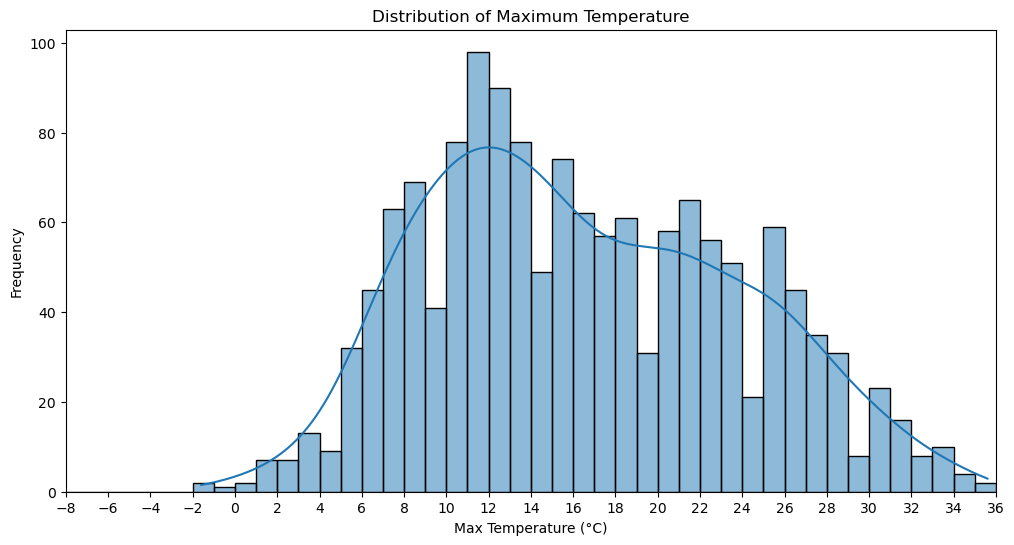

In [7]:
# %%
# Define consistent bin edges for temperature histograms
temp_min_max = df[['temp_min', 'temp_max']].agg(['min', 'max']).values
all_temp_min = temp_min_max[0, 0]
all_temp_max = temp_min_max[0, 1] if temp_min_max[0, 1] > temp_min_max[1, 1] else temp_min_max[1, 1]

# Create bins with a width of 1 degree Celsius
bins = np.arange(np.floor(all_temp_min), np.ceil(all_temp_max) + 1, 1)

plt.figure(figsize=(12,6))
sns.histplot(data=df, x='temp_max', bins=bins, kde=True)
plt.title('Distribution of Maximum Temperature')
plt.xlabel('Max Temperature (°C)')
plt.ylabel('Frequency')
plt.xlim(bins.min(), bins.max()) # Set x-axis limits
plt.xticks(bins[::2]) # Show fewer ticks for clarity
plt.show()

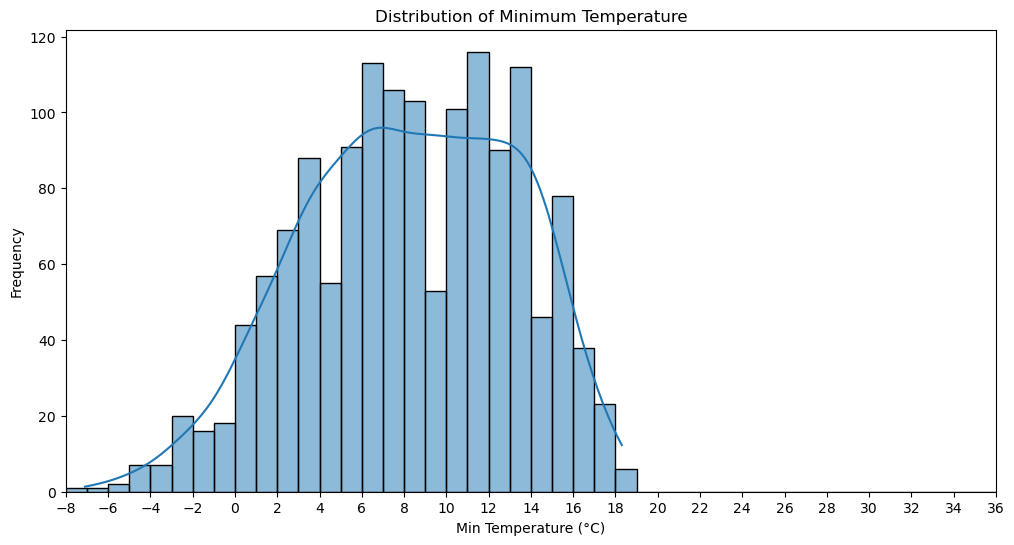

In [8]:
# %%
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='temp_min', bins=bins, kde=True)
plt.title('Distribution of Minimum Temperature')
plt.xlabel('Min Temperature (°C)')
plt.ylabel('Frequency')
plt.xlim(bins.min(), bins.max()) # Set x-axis limits
plt.xticks(bins[::2]) # Show fewer ticks for clarity
plt.show()

In [9]:
# %% [markdown]
# ### FacetGrid Visualizations (Month vs. Weather Variables by Year)
# First, convert 'date' to datetime and extract 'year' and 'month'.

# %%
def create_visualization_df(dataframe):
    """Creates a copy of the dataframe for visualization and extracts year/month."""
    df_vis = dataframe.copy()
    df_vis['year'] = df_vis['date'].dt.year
    df_vis['month'] = df_vis['date'].dt.month
    return df_vis

df_vis = create_visualization_df(df)

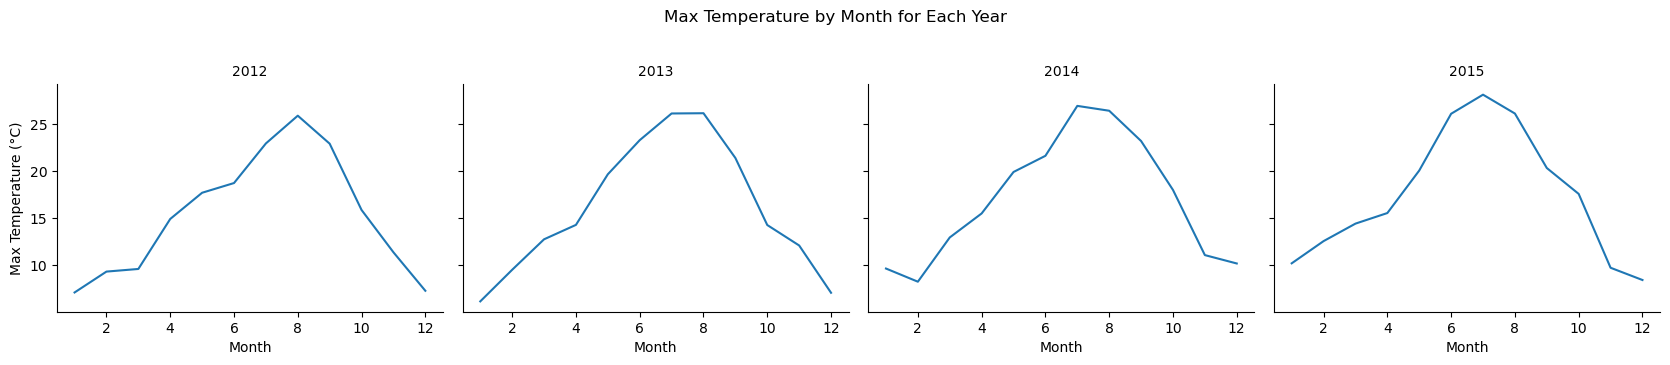

In [10]:
# %%
# Max Temperature vs. Month by Year
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'temp_max', errorbar=None) # errorbar=None to remove confidence intervals for clarity
g.set_axis_labels('Month', 'Max Temperature (°C)')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Max Temperature by Month for Each Year', y=1.03) # Add a main title
plt.tight_layout()
plt.show()

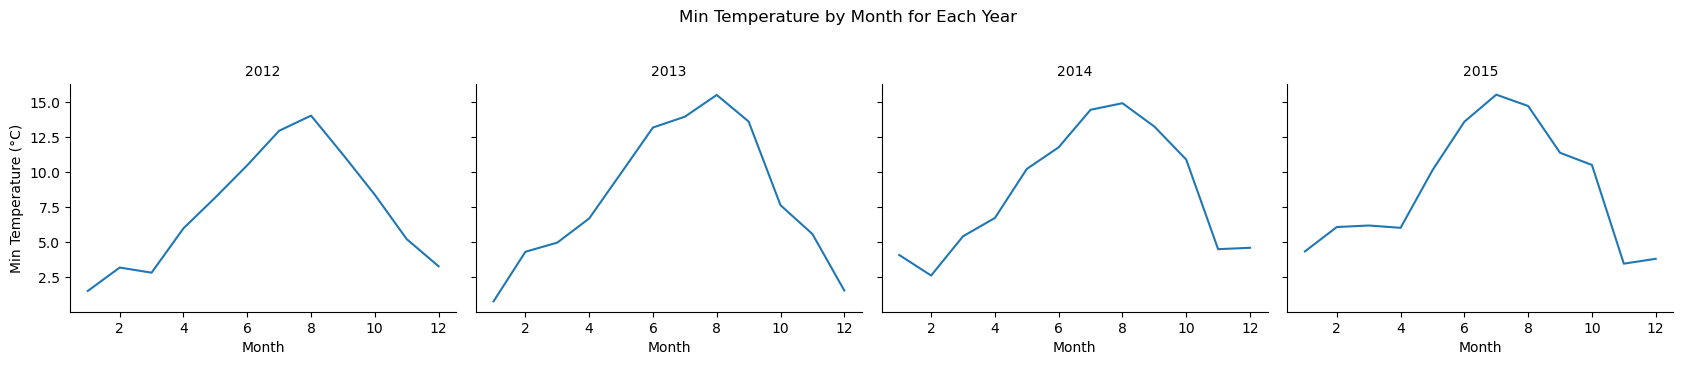

In [11]:
# %%
# Min Temperature vs. Month by Year
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'temp_min', errorbar=None)
g.set_axis_labels('Month', 'Min Temperature (°C)')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Min Temperature by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()

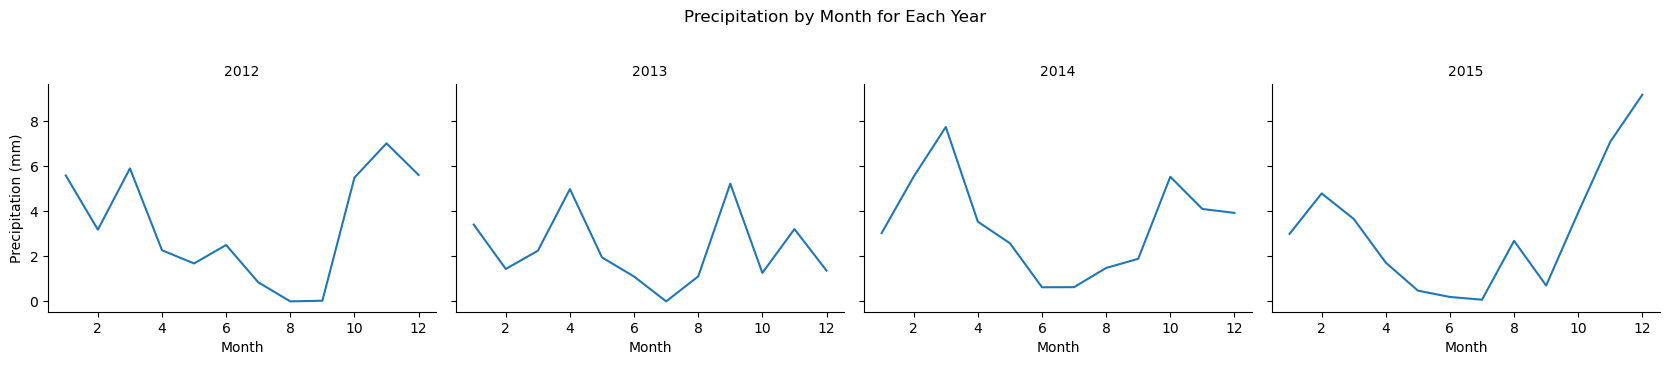

In [12]:
# %%
# Precipitation vs. Month by Year
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'precipitation', errorbar=None) # Lineplot might be better than scatter for trendsg.set_axis_labels('Month', 'Precipitation (mm)')
g.set_axis_labels('Month', 'Precipitation (mm)')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Precipitation by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()

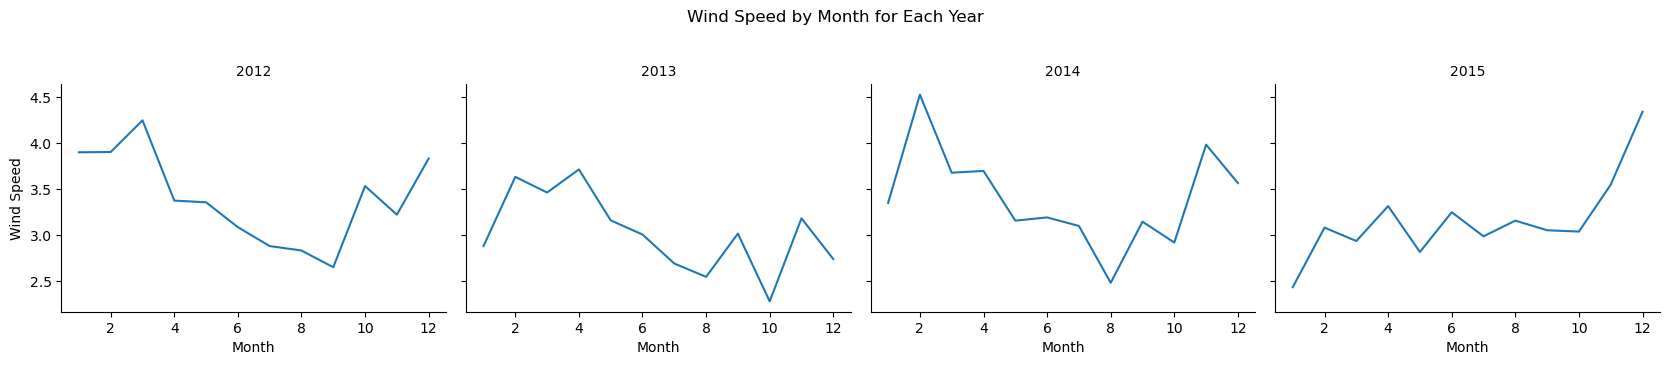

In [13]:
# %%
# Wind Speed vs. Month by Year
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'wind', errorbar=None) # Lineplot for trendsg.set_axis_labels('Month', 'Wind Speed')
g.set_axis_labels('Month', 'Wind Speed')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Wind Speed by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()

In [14]:
# %% [markdown]
# ### Weather Category Distribution

# %%
print("\nWeather Category Counts:")
weather_counts = df['weather'].value_counts()
print(weather_counts)


Weather Category Counts:
weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64


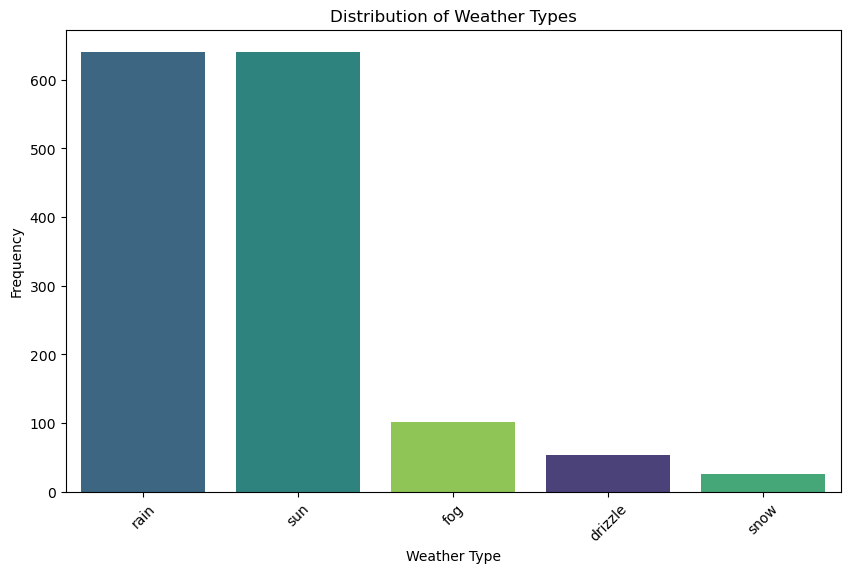

In [15]:
# %%
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='weather', order=weather_counts.index, hue='weather', palette="viridis", legend=False)
plt.title('Distribution of Weather Types')
plt.xlabel('Weather Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

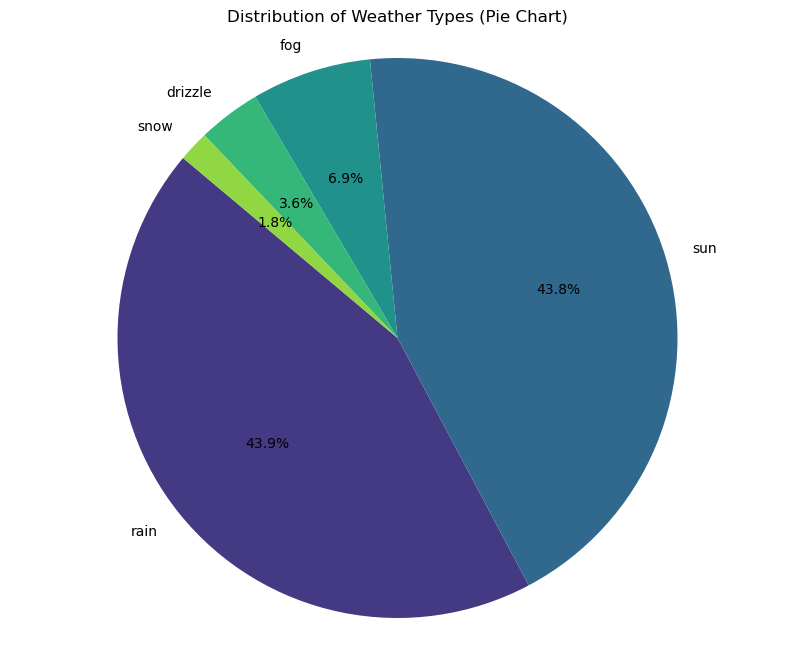

In [16]:
# %%
plt.figure(figsize=(10, 8))
plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette("viridis", len(weather_counts)))
plt.title('Distribution of Weather Types (Pie Chart)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [17]:
# %% [markdown]
# ## 3. Data Preprocessing for Classification
# The Kaggle notebook drops 'year' and 'month' after visualization and does not use 'date'.
# It then label encodes 'weather' for the target variable.

# %%
# Create a working copy of the dataframe for preprocessing
df_processed = df.copy()

In [18]:
# Drop the 'date' column as it won't be used directly as a feature in this specific approach.
# Note: For more advanced time-series models, date components or the date itself could be crucial.
# The Kaggle example's feature set is ['temp_min', 'temp_max', 'precipitation', 'wind'].
if 'date' in df_processed.columns:
    df_processed = df_processed.drop('date', axis=1)

print("\nDataFrame columns before modeling:", df_processed.columns.tolist())
df_processed.head()


DataFrame columns before modeling: ['precipitation', 'temp_max', 'temp_min', 'wind', 'weather']


,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


In [19]:
# %%
# Label Encode the target variable 'weather'
le = LabelEncoder()
df_processed['weather_encoded'] = le.fit_transform(df_processed['weather'])

# Display the mapping
print("\nLabel Encoding Mapping for 'weather':")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")


Label Encoding Mapping for 'weather':
drizzle -> 0
fog -> 1
rain -> 2
snow -> 3
sun -> 4


In [20]:
# %%
# Save the label encoder for use in the Flask app (to decode predictions)
joblib.dump(le, 'weather_label_encoder.joblib')
print("\nSaved weather_label_encoder.joblib")
df_processed.head()


Saved weather_label_encoder.joblib


,precipitation,temp_max,temp_min,wind,weather,weather_encoded
0,0.0,12.8,5.0,4.7,drizzle,0
1,10.9,10.6,2.8,4.5,rain,2
2,0.8,11.7,7.2,2.3,rain,2
3,20.3,12.2,5.6,4.7,rain,2
4,1.3,8.9,2.8,6.1,rain,2


In [21]:
# %% [markdown]
# ### Adding Lagged Time Series Features
# We'll create features based on the previous day's observations to potentially improve model performance.

# %%
# Sort by date before creating lagged features to ensure correct order
df_for_lagged = df.sort_values(by='date').copy()

In [22]:
# Label Encode the target variable 'weather' for the lagged feature
le_lag = LabelEncoder()
df_for_lagged['weather_encoded'] = le_lag.fit_transform(df_for_lagged['weather'])

In [23]:
# Create lagged features
df_for_lagged['precipitation_lag1'] = df_for_lagged['precipitation'].shift(1)
df_for_lagged['temp_max_lag1'] = df_for_lagged['temp_max'].shift(1)
df_for_lagged['temp_min_lag1'] = df_for_lagged['temp_min'].shift(1)
df_for_lagged['wind_lag1'] = df_for_lagged['wind'].shift(1)
df_for_lagged['weather_encoded_lag1'] = df_for_lagged['weather_encoded'].shift(1)

In [24]:
# You can also add delta features
df_for_lagged['delta_max_temp'] = df_for_lagged['temp_max'] - df_for_lagged['temp_max_lag1']
df_for_lagged['delta_min_temp'] = df_for_lagged['temp_min'] - df_for_lagged['temp_min_lag1']



In [25]:
# Drop rows with NaN values introduced by shifting (first row)
df_for_lagged = df_for_lagged.dropna().reset_index(drop=True)

print("\nDataFrame with Lagged Features:")
print(df_for_lagged.head())


DataFrame with Lagged Features:
        date  precipitation  temp_max  temp_min  wind weather  weather_encoded  precipitation_lag1  temp_max_lag1  temp_min_lag1  wind_lag1  weather_encoded_lag1  delta_max_temp  delta_min_temp
0 2012-01-02           10.9      10.6       2.8   4.5    rain                2                 0.0           12.8            5.0        4.7                   0.0            -2.2            -2.2
1 2012-01-03            0.8      11.7       7.2   2.3    rain                2                10.9           10.6            2.8        4.5                   2.0             1.1             4.4
2 2012-01-04           20.3      12.2       5.6   4.7    rain                2                 0.8           11.7            7.2        2.3                   2.0             0.5            -1.6
3 2012-01-05            1.3       8.9       2.8   6.1    rain                2                20.3           12.2            5.6        4.7                   2.0            -3.3            -2

In [26]:
# Use this df for training with lagged features
df_processed_lagged = df_for_lagged.drop(columns=['date', 'weather'])

In [27]:
# %% [markdown]
# ## 4. Feature Selection and Train-Test Split

# %%
# Original features based on Kaggle example
original_features = ['temp_min', 'temp_max', 'precipitation', 'wind']
X_original = df_processed[original_features]
y_original = df_processed['weather_encoded']

In [28]:
# Features including lagged data
lagged_features = ['temp_min', 'temp_max', 'precipitation', 'wind',
                   'precipitation_lag1', 'temp_max_lag1', 'temp_min_lag1',
                   'wind_lag1', 'weather_encoded_lag1',
                   'delta_max_temp', 'delta_min_temp']
X_lagged = df_processed_lagged[lagged_features]
y_lagged = df_processed_lagged['weather_encoded'] # Target remains the same

In [29]:
# Store the feature names model will be trained on (for Flask app input)
# We will use the original features for the primary model saved for Flask
feature_names_for_model = X_original.columns.tolist()
joblib.dump(feature_names_for_model, 'classifier_feature_names.joblib')
print(f"Saved classifier_feature_names.joblib with features: {feature_names_for_model}")

Saved classifier_feature_names.joblib with features: ['temp_min', 'temp_max', 'precipitation', 'wind']


In [30]:
# Split data - using random split as per Kaggle example for primary model
# stratify=y is good for imbalanced classes
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)
print(f"\nOriginal X_train shape: {X_train_original.shape}, y_train shape: {y_train_original.shape}")
print(f"Original X_test shape: {X_test_original.shape}, y_test shape: {y_test_original.shape}")



Original X_train shape: (1168, 4), y_train shape: (1168,)
Original X_test shape: (293, 4), y_test shape: (293,)


In [31]:
# Split data for lagged features
X_train_lagged, X_test_lagged, y_train_lagged, y_test_lagged = train_test_split(
    X_lagged, y_lagged, test_size=0.2, random_state=42, stratify=y_lagged
)
print(f"\nLagged X_train shape: {X_train_lagged.shape}, y_train shape: {y_train_lagged.shape}")
print(f"Lagged X_test shape: {X_test_lagged.shape}, y_test shape: {y_test_lagged.shape}")


Lagged X_train shape: (1168, 11), y_train shape: (1168,)
Lagged X_test shape: (292, 11), y_test shape: (292,)


In [32]:
# %% [markdown]
# ## 5. Naïve Model (Climate Prediction)
# A simple baseline model that predicts the most frequent weather type for each month.

# %%
# Extract month from date for the naive model
df_naive = df.copy()
df_naive['month'] = df_naive['date'].dt.month

In [33]:
# Determine the most frequent weather type for each month
monthly_most_frequent_weather = df_naive.groupby('month')['weather'].agg(lambda x: x.mode()[0])
print("\nMost frequent weather type per month (Naïve Model):")
print(monthly_most_frequent_weather)


Most frequent weather type per month (Naïve Model):
month
1     rain
2     rain
3     rain
4     rain
5      sun
6      sun
7      sun
8      sun
9      sun
10    rain
11    rain
12    rain
Name: weather, dtype: object


In [34]:
# Evaluate the naive model
# To do this properly, we'd need to simulate predictions for each day and compare
# For simplicity, let's just see what the overall accuracy would be if we predicted the most
# frequent weather type for each month on the entire dataset.
# This isn't a true test-set evaluation but gives an idea of a very simple baseline.

df_naive['predicted_weather_naive'] = df_naive['month'].map(monthly_most_frequent_weather)
naive_accuracy = accuracy_score(df_naive['weather'], df_naive['predicted_weather_naive'])

print(f"\nNaïve Model Accuracy (Predicting most frequent weather by month): {naive_accuracy:.4f}")
print("This simple model predicts the 'climate' for each month, rather than specific 'weather'.")



Naïve Model Accuracy (Predicting most frequent weather by month): 0.6003
This simple model predicts the 'climate' for each month, rather than specific 'weather'.


In [35]:
# ## 6. Model Training and Evaluation

# %%
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, target_names, model_name="Model"):
    """Trains a model and prints evaluation metrics."""
    print(f"\n--- {model_name} Training and Evaluation ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, target_names=target_names, zero_division=0)

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    print("\nClassification Report:")
    print(classification_rep)
    return model, accuracy


--- Gaussian Naive Bayes (Original Features) Training and Evaluation ---

Accuracy: 0.8259

Confusion Matrix:


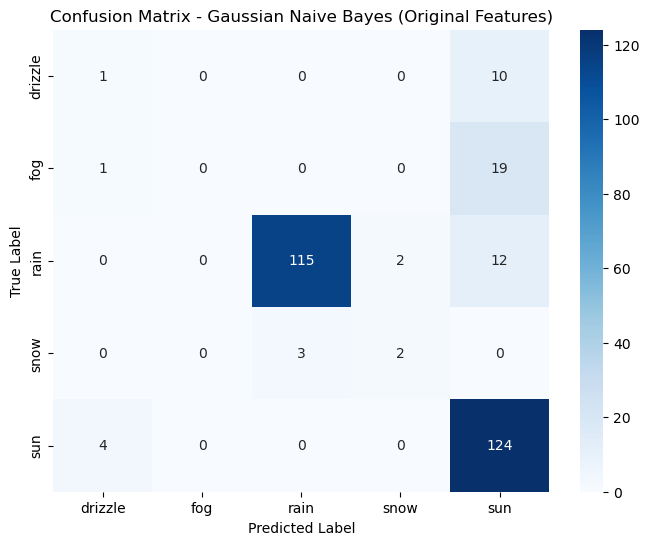


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.17      0.09      0.12        11
         fog       0.00      0.00      0.00        20
        rain       0.97      0.89      0.93       129
        snow       0.50      0.40      0.44         5
         sun       0.75      0.97      0.85       128

    accuracy                           0.83       293
   macro avg       0.48      0.47      0.47       293
weighted avg       0.77      0.83      0.79       293



In [36]:
# --- Gaussian Naive Bayes (Original Features) ---
nb_model_original, nb_accuracy_original = train_and_evaluate_model(
    GaussianNB(), X_train_original, y_train_original, X_test_original, y_test_original,
    le.classes_, "Gaussian Naive Bayes (Original Features)"
)


--- Gaussian Naive Bayes (Lagged Features) Training and Evaluation ---

Accuracy: 0.8014

Confusion Matrix:


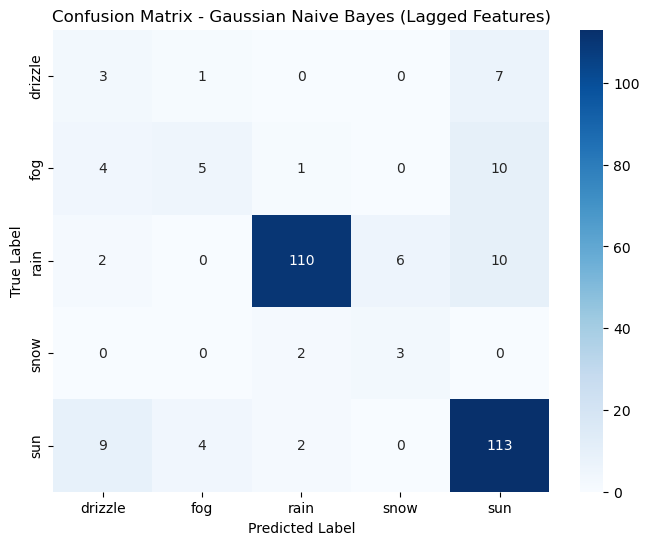


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.17      0.27      0.21        11
         fog       0.50      0.25      0.33        20
        rain       0.96      0.86      0.91       128
        snow       0.33      0.60      0.43         5
         sun       0.81      0.88      0.84       128

    accuracy                           0.80       292
   macro avg       0.55      0.57      0.54       292
weighted avg       0.82      0.80      0.80       292



In [37]:
# --- Gaussian Naive Bayes (Lagged Features) ---
nb_model_lagged, nb_accuracy_lagged = train_and_evaluate_model(
    GaussianNB(), X_train_lagged, y_train_lagged, X_test_lagged, y_test_lagged,
    le_lag.classes_, "Gaussian Naive Bayes (Lagged Features)"
)


--- Logistic Regression (Original Features) Training and Evaluation ---

Accuracy: 0.8259

Confusion Matrix:


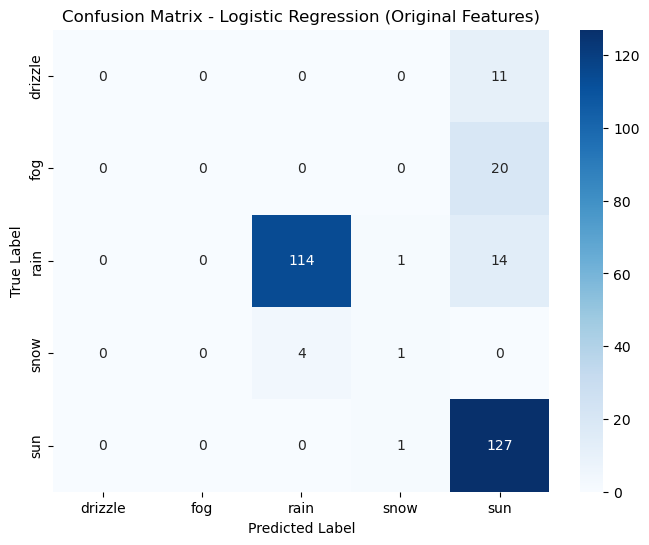


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00        11
         fog       0.00      0.00      0.00        20
        rain       0.97      0.88      0.92       129
        snow       0.33      0.20      0.25         5
         sun       0.74      0.99      0.85       128

    accuracy                           0.83       293
   macro avg       0.41      0.42      0.40       293
weighted avg       0.75      0.83      0.78       293



In [38]:
# --- Logistic Regression (Original Features) ---
lr_model_original, lr_accuracy_original = train_and_evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42), X_train_original, y_train_original, X_test_original, y_test_original,
    le.classes_, "Logistic Regression (Original Features)"
)


--- Support Vector Machine (Original Features) Training and Evaluation ---

Accuracy: 0.7611

Confusion Matrix:


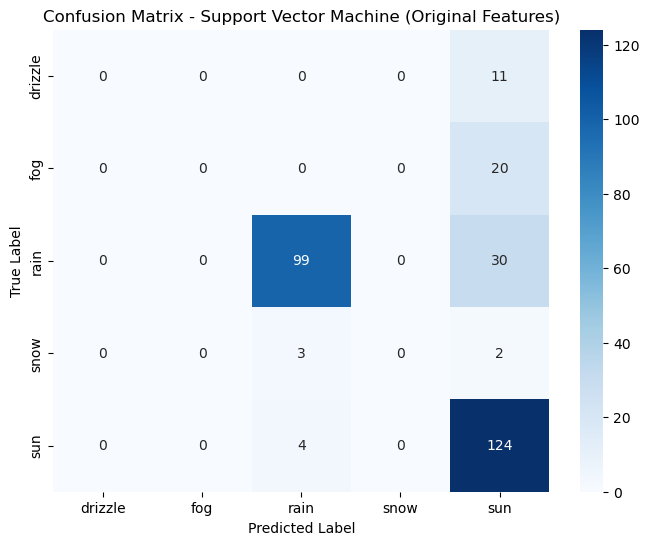


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.00      0.00      0.00        11
         fog       0.00      0.00      0.00        20
        rain       0.93      0.77      0.84       129
        snow       0.00      0.00      0.00         5
         sun       0.66      0.97      0.79       128

    accuracy                           0.76       293
   macro avg       0.32      0.35      0.33       293
weighted avg       0.70      0.76      0.71       293



In [39]:
# --- Support Vector Machine (Original Features) ---
# For SVM, using a linear kernel for simplicity and speed. RBF is also common but can be slower.
# Adjust 'C' for regularization if needed.
svm_model_original, svm_accuracy_original = train_and_evaluate_model(
    SVC(random_state=42), X_train_original, y_train_original, X_test_original, y_test_original,
    le.classes_, "Support Vector Machine (Original Features)"
)


In [42]:
# %% [markdown]
# ## 7. Ablation Study
# Let's see how different features contribute to the model's performance (using Gaussian Naive Bayes with original features).

# %%
features_to_ablate = [
    ['temp_min', 'temp_max', 'precipitation', 'wind'],
    ['temp_min', 'temp_max', 'precipitation'],
    ['temp_min', 'temp_max', 'wind'],
    ['precipitation', 'wind'],
    ['temp_max'],
    ['wind']
]

ablation_results = {}

print("\n--- Ablation Study (Gaussian Naive Bayes with Original Features) ---")
for i, current_features in enumerate(features_to_ablate):
    print(f"\nTraining with features: {current_features}")
    X_ablation = df_processed[current_features]
    y_ablation = df_processed['weather_encoded']

    X_train_ab, X_test_ab, y_train_ab, y_test_ab = train_test_split(
        X_ablation, y_ablation, test_size=0.2, random_state=42, stratify=y_ablation
    )

    model = GaussianNB()
    model.fit(X_train_ab, y_train_ab)
    y_pred_ab = model.predict(X_test_ab)
    accuracy_ab = accuracy_score(y_test_ab, y_pred_ab)
    ablation_results[tuple(current_features)] = accuracy_ab
    print(f"Accuracy: {accuracy_ab:.4f}")

print("\n--- Ablation Study Summary ---")
for features, acc in ablation_results.items():
    print(f"Features: {features} -> Accuracy: {acc:.4f}")


--- Ablation Study (Gaussian Naive Bayes with Original Features) ---

Training with features: ['temp_min', 'temp_max', 'precipitation', 'wind']
Accuracy: 0.8259

Training with features: ['temp_min', 'temp_max', 'precipitation']
Accuracy: 0.8294

Training with features: ['temp_min', 'temp_max', 'wind']
Accuracy: 0.5768

Training with features: ['precipitation', 'wind']
Accuracy: 0.8362

Training with features: ['temp_max']
Accuracy: 0.6109

Training with features: ['wind']
Accuracy: 0.5154

--- Ablation Study Summary ---
Features: ('temp_min', 'temp_max', 'precipitation', 'wind') -> Accuracy: 0.8259
Features: ('temp_min', 'temp_max', 'precipitation') -> Accuracy: 0.8294
Features: ('temp_min', 'temp_max', 'wind') -> Accuracy: 0.5768
Features: ('precipitation', 'wind') -> Accuracy: 0.8362
Features: ('temp_max',) -> Accuracy: 0.6109
Features: ('wind',) -> Accuracy: 0.5154


In [43]:
# %% [markdown]
# ## 8. Save the Model for Flask App
# We'll save the best performing model (or the original Gaussian Naive Bayes as initially planned) and the label encoder.
# For demonstration, we'll save the original Gaussian Naive Bayes model.

# %%
# Save the Gaussian Naive Bayes model (using original features)
joblib.dump(nb_model_original, 'weather_prediction_model.joblib')
print("\nSaved weather_prediction_model.joblib (Gaussian Naive Bayes with original features)")

print("\nNotebook execution complete!")


Saved weather_prediction_model.joblib (Gaussian Naive Bayes with original features)

Notebook execution complete!
